# COGS 108 Final Project

## Group Members: 
- A14178715
- A11475687
- A12594395
- A11729103

### Introduction and Background:

What would it look like if we visualized a predicted sea level rise for the future? How accurate can we get based on a large dataset of the sea level rising over a long period of time?

Well, we should see a fairly accurate model of future sea level, represented by a map of the coastal regions of California flooded. This model will get less and less accurate the further we go into the future. To start, we need data. Here is a good one:

ftp://podaac.jpl.nasa.gov/allData/merged_alt/L2/TP_J1_OSTM/global_mean_sea_level/GMSL_TPJAOS_V4_199209_201702.txt

ftp://podaac.jpl.nasa.gov/allData/merged_alt/L2/TP_J1_OSTM/global_mean_sea_level/GMSL_TPJAOS_V4_199209_201703.txt (updated link, we downloaded the data from the first link while it still worked)

This is NASA's data on calculating the sea level increase with satellites. The link worked a while back, but no longer works, so we downloaded the data while it was available and have included it in our repository.


### Data Description:

NASA's description of the data:

"Global Mean Sea Level Data"
This file contains Global Mean Sea Level (GMSL) variations computed at the NASA Goddard Space Flight Center under the 
auspices of the NASA MEaSUREs program. The GMSL was generated using the Integrated Multi-Mission Ocean Altimeter Data for Climate Research (http://podaac.jpl.nasa.gov/dataset/MERGED_TP_J1_OSTM_OST_ALL_V4). It combines Sea Surface Heights from TOPEX/Poseidon, Jason-1, OSTM/Jason-2, and Jason-3 to a common terrestrial reference frame with all inter-mission biases, range and geophysical corrections applied and placed onto a georeferenced orbit. This creates a consistent data record throughout time, regardless of the instrument used."

### Starting out: imports

In [1]:
# imports
import csv                                        # for loading in our .txt file data (as csv)
import itertools                                  # for better iterating
import pandas as pd                               # for reading csv
import matplotlib as plt                          # for plotting
import datetime                                   # for converting fractional years to real dates
import patsy                                      # for prediction
import statsmodels.api as sm                      # for prediction
import statsmodels.formula.api as smf             # for prediction
import IPython                                    # for displaying a map in an iframe at the end
from sklearn.linear_model import LinearRegression # more prediction tools
%matplotlib inline
  

### Data Cleaning and Pre-processing

In [2]:
txtFile = "nasa_data_noheader.txt"
csvFile = "data.csv"
def processTxt(txtFile):
    with open(txtFile,'r') as in_file:
        # Our lines in nasa data have 1-4 spaces of separation so first we split the line
        stripped = (line.strip() for line in in_file)
        lines = (line.split(" ") for line in stripped if line)
        
        # Then here we write it to the csv and if there is an empty space it will replace it with nothing 
        with open(csvFile,'w') as out_file:
            # Column titles (adds empty row 2 we can just delete once its in pandas dataframe)
            writer = csv.writer(out_file)
            writer.writerow(('altimeter_type', 'file_cycle_#','date','obs_#','weighted_obs_#','mean_variation','std_dev_of_mean_var','smoothed_variation1','smoothed_variation2','std_dev_of_mean_var2','smoothed_variation3','smoothed_variation4', 'col12'))
            # for the above line, there are many extra and redundant forms of the data, such as GIA applied vs not applied. These columns are explained in the data.
            # four our purposes, we only need a few of these columns, such as date, so the rest were not labelled in detail.
            for line in lines:
                for index in line:
                    # Replacing the white space with nothing
                    index.replace(" ", "") 
                    if index != "":
                        out_file.write(index + ",")
                out_file.write('\n')
processTxt(txtFile)


df = pd.read_csv('data.csv')
# remove the extra row (row2), drops only if all col = nan
df = df.dropna(how = 'all')

# make a new dataframe without the columns we don't need
df2 = df[['date', 'mean_variation', 'smoothed_variation3']].copy()

# print the dataframe so we know we are on the right track
df2

,date,mean_variation,smoothed_variation3
0,1993.011475,-40.28,-40.63
1,1993.038696,-44.20,-41.89
2,1993.065918,-44.17,-42.02
3,1993.093018,-46.32,-42.36
4,1993.120239,-40.91,-41.57
5,1993.147339,-39.32,-40.50
6,1993.174561,-38.86,-39.52
7,1993.201660,-37.62,-38.80
8,1993.228882,-37.80,-38.39
9,1993.255981,-45.73,-38.27


In [3]:
# because the data point in every column of variation starts negative, we need to make them start at 0 for pretty plotting. 
# add 40.28 to every data point in the mean_variation column and 40.63 to every column in the smoothed_variation3 column
# this brings the floor of our data up to get it to look more like the plot on NASA's page: 
# https://climate.nasa.gov/vital-signs/sea-level/
df2['mean_variation'] += 40.28
df2['smoothed_variation3'] += 40.63

# lastly, change the dates to human readable dates that are easier to plot, like NASA did for their plot. 
# the dates are in fractions of years. They need to be converted to real dates, readable by people.

def human_date(date):
    days = (float(str(date-int(date))[1:]) * 365);
    return datetime.datetime(int(date), 1, 1) + datetime.timedelta(days - 1)

converted_dates = []

for index, row in df2.iterrows():
    converted_dates.append(human_date(row['date']))
    
df2 = df2.assign(human_readable = converted_dates)

### Data Visualization

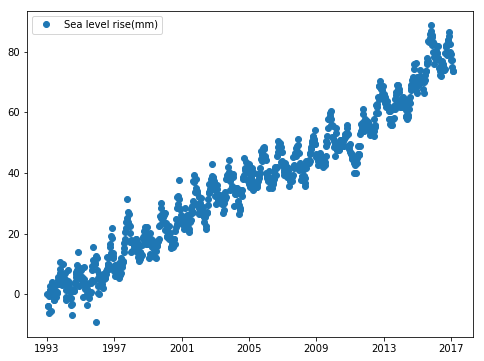

In [4]:
# plot data using plt.something()

fig, ax = plt.pyplot.subplots(figsize=(8,6))

ax.plot(df2['human_readable'], df2['mean_variation'], 'o', label="Sea level rise(mm)")
legend = ax.legend(loc="best")

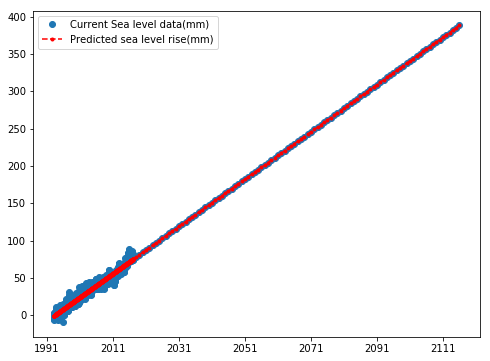

In [5]:
# predict future sea level rise for the next 100 years

smresults = smf.ols('mean_variation ~ date', df2).fit()

index = 888
for i in range(2017, 2117):
    prediction = smresults.predict(pd.DataFrame({'intercept': 1, 'date': [i]}))
    series = pd.Series([int(i),float(prediction),0,human_date(float(i))], 
                       index=['date', 'mean_variation', 'smoothed_variation3', 'human_readable'], name=str(index))
    df2 = df2.append(series)
    index += 1

fig, ax = plt.pyplot.subplots(figsize=(8,6))
outcome_1, predictors_1 = patsy.dmatrices('mean_variation ~ date', df2)
mod_1 = smf.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

ax.plot(df2['human_readable'], df2['mean_variation'], 'o', label="Current Sea level data(mm)")
ax.plot(df2['human_readable'], res_1.fittedvalues, 'r--.', label="Predicted sea level rise(mm)")
legend = ax.legend(loc="best")

In [5]:
# show what this prediction looks like in a google map

iframe = '<iframe style="width:780px;height:550px" src="http://flood.firetree.net/embed.php?w=780&h=600&ll=32.7%2C-117.16&z=6" scrolling="no" frameborder="no" marginheight="0"></iframe>'
IPython.display.HTML(iframe)

### Conclusions and Discussion:

If the map above does not show in the cell, you may have to run the cell. 

In the map above, choose "+1 m" from the drop down selector to see a fairly accurate map of our future prediction for the next 100 years (0.4 meters every 100 years).

We ended up using many more imports, many for cleaning and reformatting the data. We could have plotted the data anyway, but the imports let us make the data pretty for plotting, such as changing fractional years to human-readable years. 

Due to the total volume of glacial ice melting to raise the sea level, as well as countermeasures put in place by people in the future, the rate at which the sea level rises will probably not be as constant as we predicted. NASA predicted that the sea level rises 3.4 mm annually, which our plot shows. Annoyingly, we had to add data after getting the line of best fit in order to extend the line to 100 years in the future.
